# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 7
# LDA/QDA and Decision Trees

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display, Math, Latex
from sklearn import grid_search
%matplotlib inline

/Users/rmitchell/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rmitchell/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)



## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `hw7_dataset.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI machine learning repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the following code:

In [3]:
np.random.seed(9001)
df = pd.read_csv('./data/hw7_dataset.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [4]:
print ("Shape of data_train: " + str(data_train.shape))
print ("Shape of data_test:  "  + str(data_test.shape))
display (data_train.head())
display (data_train.describe())
Xtrain = data_train[['Biomarker 1', 'Biomarker 2']]
ytrain = data_train['Diagnosis']
Xtest  = data_test[['Biomarker 1', 'Biomarker 2']]
ytest  = data_test['Diagnosis']

Shape of data_train: (102, 3)
Shape of data_test:  (113, 3)


,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


,Biomarker 1,Biomarker 2,Diagnosis
count,102.000000,102.000000,102.000000
mean,0.344213,0.136095,1.392157
std,0.830087,2.201512,0.677164
min,-2.302485,-11.512925,1.000000
25%,-0.105349,-1.076236,1.000000
50%,0.222351,0.641859,1.000000
75%,0.470010,1.273894,2.000000
max,4.032469,3.970292,3.000000


## Question 1: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the training and test sets?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
    <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

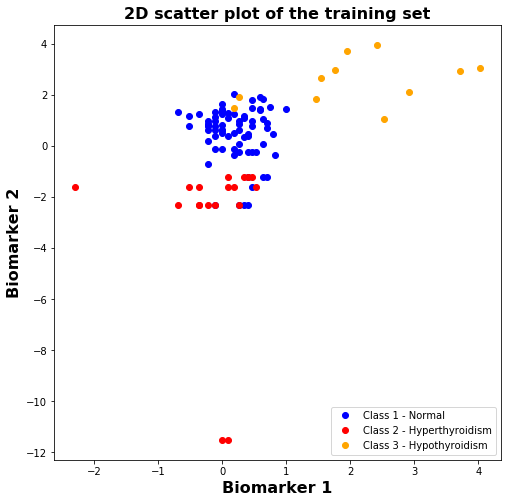

In [5]:
# Generate a 2D scatter plot of the training set, 
# denoting each class with a different color. 

categories   = list(data_train.Diagnosis.unique())
colors       = ['blue', 'red', 'orange']
color_labels = ['Class 1 - Normal',
                'Class 2 - Hyperthyroidism',
                'Class 3 - Hypothyroidism']
plt.figure(figsize = (8,8))
for ind1, category in enumerate(categories):
    data_train_cat = (data_train[data_train.Diagnosis == category])
    plt.plot(data_train_cat['Biomarker 1'], 
             data_train_cat['Biomarker 2'],
             'ro',
             color = colors[ind1],
             label = color_labels[ind1]
            )
plt.xlabel('Biomarker 1', fontsize = 16, fontweight='bold')
plt.ylabel('Biomarker 2', fontsize = 16, fontweight='bold')
plt.title('2D scatter plot of the training set', fontsize = 16, fontweight='bold')
plt.legend(loc = 'lower right')
plt.show()

In [5]:
# Multinomial Logistic Regression using LogisticRegressionCV with
#   L2 regularization
#   Multi_class option 'multinomial'

import time

mlr_mod = LogisticRegressionCV(penalty='l2', multi_class='multinomial') 
start = time.time()
mlr_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print ("Multinomial Logistic Regression (MLR) Train Accuracy:  " + 
       str(mlr_mod.score(Xtrain, ytrain)))
print ("Multinomial Logistic Regression (MLR) Test Accuracy:   " + 
       str(mlr_mod.score(Xtest, ytest)))
print("Fit time: "+str(totalTime))


Multinomial Logistic Regression (MLR) Train Accuracy:  0.892156862745
Multinomial Logistic Regression (MLR) Test Accuracy:   0.884955752212
Fit time: 0.1782371997833252


In [6]:
# One Vs Rest Classifier using LogisticRegressionCV with
#   L2 regularization
#   Multi_class option 'ovr'

ovr_mod = LogisticRegressionCV(penalty='l2', multi_class='ovr')
start = time.time()
ovr_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print ("OVR Train Accuracy:  " + str(ovr_mod.score(Xtrain, ytrain)))
print ("OVR Test Accuracy:   " + str(ovr_mod.score(Xtest, ytest)))
print("Fit time: "+str(totalTime))

OVR Train Accuracy:  0.843137254902
OVR Test Accuracy:   0.840707964602
Fit time: 0.19275593757629395


In [7]:
# Multinomial Logistic Regression using LogisticRegressionCV with
#   L2 regularization
#   Multi_class option 'ovr'
poly = PolynomialFeatures(degree=2)
mlr_poly_mod = LogisticRegressionCV(penalty='l2', multi_class='multinomial')

# Calculate the time for creating the polynomial training set and fitting the model
start = time.time()
Xtrain_poly = poly.fit_transform(Xtrain)
mlr_poly_mod.fit(Xtrain_poly, ytrain)
totalTime = time.time() - start

Xtest_poly = poly.fit_transform(Xtest)
print ("MLR with 2nd order polynomial terms Train Accuracy:  " + 
       str(mlr_poly_mod.score(Xtrain_poly, ytrain)))
print ("MLR with 2nd order polynomial terms Test Accuracy:   " + 
       str(mlr_poly_mod.score(Xtest_poly, ytest)))
print("Fit time: "+str(totalTime))

MLR with 2nd order polynomial terms Train Accuracy:  0.892156862745
MLR with 2nd order polynomial terms Test Accuracy:   0.893805309735
Fit time: 0.609299898147583


In [8]:
#  Linear Discriminant Analysis
lda_mod = LDA()
start = time.time()
lda_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print ("LDA Train Accuracy:  " + str(lda_mod.score(Xtrain, ytrain)))
print ("LDA Test Accuracy:   " + str(lda_mod.score(Xtest, ytest)))
print("Fit time: "+str(totalTime))

LDA Train Accuracy:  0.872549019608
LDA Test Accuracy:   0.83185840708
Fit time: 0.0034279823303222656


In [9]:
# Quadratic Discriminant Analysis
qda_mod = QDA()
start = time.time()
qda_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print ("QDA Train Accuracy:  " + str(qda_mod.score(Xtrain, ytrain)))
print ("QDA Test Accuracy:   " + str(qda_mod.score(Xtest, ytest)))
print("Fit time: "+str(totalTime))

QDA Train Accuracy:  0.872549019608
QDA Test Accuracy:   0.849557522124
Fit time: 0.0027883052825927734


In [10]:
# k-Nearest Neighbors 
# Using Gridsearch to find optimal n_neighbors with 5-fold cross-validation
parameters = {'n_neighbors':list(range(2,20,1))}
knc_mod = grid_search.GridSearchCV(KNeighborsClassifier(), 
                                   parameters, 
                                   cv = 5,
                                   n_jobs=4)
start = time.time()
knc_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print (knc_mod.best_score_, knc_mod.best_params_) 

# Fit model with optimal 'n_neighbors' parameter
knc_mod_best = KNeighborsClassifier(n_neighbors = knc_mod.best_params_['n_neighbors'])
knc_mod_best.fit(Xtrain, ytrain) 

print ("\nk-Nearest Neighbors (k = %s) Train Accuracy: %f" % 
       (knc_mod.best_params_['n_neighbors'], knc_mod_best.score(Xtrain, ytrain)))
print ("k-Nearest Neighbors (k = %s)  Test Accuracy: %f" % 
       (knc_mod.best_params_['n_neighbors'], (knc_mod_best.score(Xtest, ytest))))
print("Fit time: "+str(totalTime))

0.9019607843137255 {'n_neighbors': 3}

k-Nearest Neighbors (k = 3) Train Accuracy: 0.931373
k-Nearest Neighbors (k = 3)  Test Accuracy: 0.867257
Fit time: 0.29727911949157715


#### Q: Does it appear that the data points can be separated well by a linear classifier?

A linear classifier may give an adequate result, although a performance improvement may be seen by a non-linear separation between the class 1 and class 2 (red and blue, above) to separate between the major blobs at x=-1, and also to separate the class 1 points to the right of the the larger mass of class 2 points

#### Q: Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

A multinomial logistic regression uses multiple logistic equations to calculate the relative odds of all classes at once. A one-vs-rest logistic regression creates multiple logistic regression models, each one modeling the odds of "one class vs. every other class" and stacking the models to create a single model.


#### Q: Is there a difference in the overall classification accuracy of the two methods on the training and test sets?
Multinomial regression performed better overall on both the training and test sets, but the classification score fell from training to test. One-vs-rest had a classification score about 5% less, but performed similarly on both the training and test set.

#### Q: Compare the training and test accuracies of the following six (6) models:

Classification Model|Train Accuracy|Test Accuracy
    ---------------------------------------------------:|-------------:|-------------:|
    Multinomial Logistic Regression|0.8922|0.8850|
    one-vs-rest (OvR) logistic regression|0.8431|0.8407|
    Multiclass Logistic Regression with quadratic terms|0.8922|0.8938|
    Linear Discriminant Analysis|0.8725|0.8319|
    Quadratic Discriminant Analysis|0.8725|0.8495|
    k-Nearest Neighbors |0.9314|0.8673|
    


#### Q: Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms?

Test accuracy is marginally better, by 0.8%, with inclusion of the 2nd order polynomial terms.

## Question 2: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [11]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous part.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

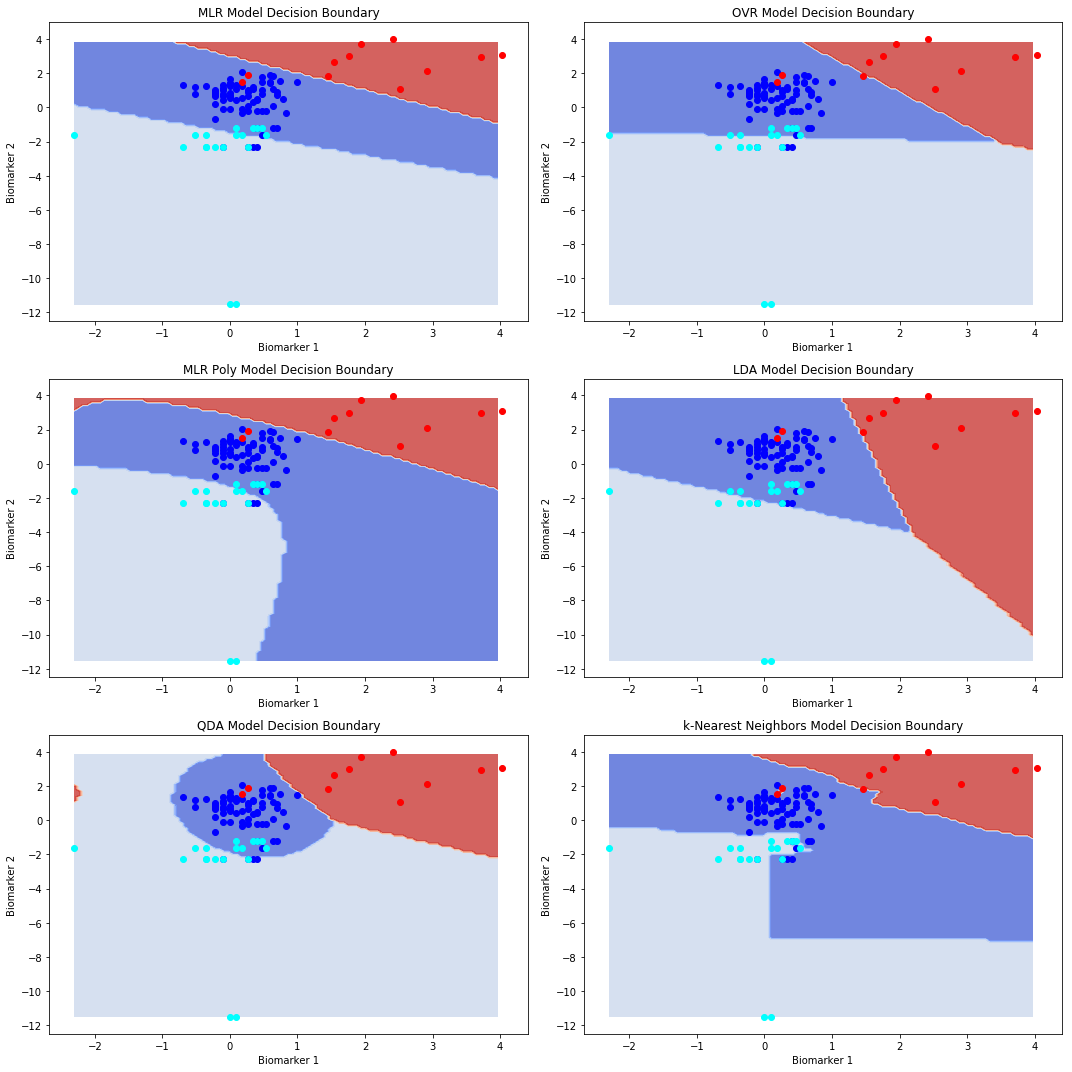

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

ax[0][0] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), mlr_mod, 
                                  'MLR Model Decision Boundary', ax[0][0], poly_degree = None)

ax[0][1] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), ovr_mod, 
                                  'OVR Model Decision Boundary', ax[0][1], poly_degree = None)

ax[1][0] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), mlr_poly_mod, 
                                  'MLR Poly Model Decision Boundary', ax[1][0], poly_degree = 2)

ax[1][1] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), lda_mod, 
                                  'LDA Model Decision Boundary', ax[1][1], poly_degree = None)
ax[2][0] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), qda_mod, 
                                  'QDA Model Decision Boundary', ax[2][0], poly_degree = None)
ax[2][1] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), knc_mod_best, 
                                  'k-Nearest Neighbors Model Decision Boundary', ax[2][1], poly_degree = None)
plt.tight_layout()
plt.show()


#### Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. 

The decision boundaries for both models are linear and similar to each other, except in the upper right section of the plot where the OvR decision boundaries for all three classes meet at a single point.

#### Q: Is there a difference between the decision boundaries for the linear logistic regression models and LDA?

*Multinomial logistic regression (MLR) and LDA decision boundary comparison*
- The decision boundaries are linear for both models.  
- The LDA plot has a decision boundary between every class pair combination (3) while the the MLR plot has decision boundaries between two (2) class pairs.
- The decision boundary between the light blue and blue class is very similar for both models, except on the rightmost quarter of the LDA plot where all decision boundaries meet at a single point and where the decision boundary for red extends further down the rightside of the plot.  The expansion of the red decision boundary in that are of the LDA plot is expected since data points in that region are closest to the red cluster from an LDA perspective.

*OvR and LDA decision boundary comparison* 
- The OvR and LDA decision boundaries are more similar than the MLR and LDA decision boundaries.
- The decision boundaries are linear for both models. 
- All decision boundaries converge to a single poin.
- There is more expansion of the red decision boundary in the lower rightmost portion of the LDA plot as described previously.



#### Q: What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

Both quadratic logistic regression and QDA have curved decision boundaries.  QDA has curved decision boundaries because it assumes the covariance can be different for each cluster, unlike LDA.  Quadratic logistic regression has curved decision boundaries due to the inclusion of quadratic (polynomial degree 2) terms.


## Question 3: Fit Decision Trees

We next try out decision trees for thyroid classification. For the following questions, you may use the *Gini* index as the splitting criterion while fitting the decision tree. 
1. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the training and test accuracies as a function of the tree depth. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about the test accuracy of this model?

2. Use 5-fold cross-validation to find the optimal tree depth. How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?

3. Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.

4. Use the `export_graphviz` function in `sklearn` to generate a visualization of the tree diagram for the fitted model. Based on the visualization, explain *in words* how the fitted model diagnoses 'hypothyroidism' for a patient.  


*Note:* Look at the `export_graphviz` function in the `sklearn.tree` module. 

You can get a graphic for this visualization by pasting the generated graphviz file in the text box at http://www.webgraphviz.com/ , or you can do it on your own computer.

If you choose the do the latter, you will have to install `GraphViz` and `pydot` to use the decision tree rendering code. For this, you may execute the following commands in a terminal:

`$pip install graphviz`<br>
`$pip install pydot`

*Hint:* You may use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth. You may use the `cross_val_score` function for cross-validation with decision trees.

range(2, 11)
{'test': [0.87610619469026552, 0.87610619469026552, 0.88495575221238942, 0.86725663716814161, 0.84955752212389379, 0.84955752212389379, 0.84955752212389379, 0.84955752212389379, 0.84955752212389379], 'train': [0.92156862745098034, 0.92156862745098034, 0.96078431372549022, 0.96078431372549022, 0.97058823529411764, 0.97058823529411764, 0.97058823529411764, 0.97058823529411764, 0.97058823529411764]}


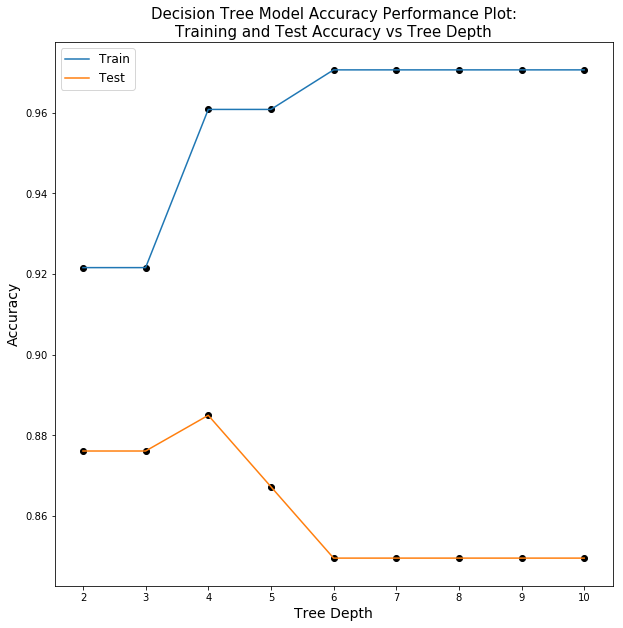

In [13]:
# Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. 
# Make plots of the training and test accuracies as a function of the tree depth. 
tree_depths = range(2,11)
dtc_mod_acc = {'test':[], 'train': []}
for tree_depth in tree_depths:
    dtc_mod = DecisionTreeClassifier(max_depth = tree_depth)
    dtc_mod.fit(Xtrain, ytrain)
    dtc_mod_acc['train'].append(dtc_mod.score(Xtrain, ytrain))
    dtc_mod_acc['test'].append(dtc_mod.score(Xtest, ytest))

print(tree_depths)
print(dtc_mod_acc)
plt.figure(figsize = (10, 10))
plt.plot(tree_depths, dtc_mod_acc['train'], label='Train')
plt.plot(tree_depths, dtc_mod_acc['test'], label='Test')
plt.scatter(tree_depths, dtc_mod_acc['train'], c='k')
plt.scatter(tree_depths, dtc_mod_acc['test'], c='k')
plt.axis('tight')
plt.xlabel('Tree Depth', fontsize = 14)
plt.ylabel('Accuracy',   fontsize = 14)
plt.legend(fontsize = 12)
plt.title("Decision Tree Model Accuracy Performance Plot:\nTraining and Test Accuracy vs Tree Depth",
         fontsize = 15)
plt.show()


In [14]:
# Using Gridsearch to find optimal tree depth with 5-fold cross-validation
from sklearn import grid_search
parameters = {'max_depth':list(range(2,11))}
dtc_gs_mod = grid_search.GridSearchCV(DecisionTreeClassifier(), 
                                   parameters, 
                                   cv = 5,
                                   n_jobs=4)
dtc_gs_mod.fit(Xtrain, ytrain)
print (dtc_gs_mod.best_score_, dtc_gs_mod.best_params_) 

0.9117647058823529 {'max_depth': 2}


In [15]:
# Same thing as above but using cross_val_score
import operator
tree_depths = range(2,11)
dtc_mod_acc = {'test':[], 'train': []}
score_ave = {}
depth = {}
for tree_depth in tree_depths:
    dtc_mod = DecisionTreeClassifier(max_depth = tree_depth)
    # Perform 5-fold cross validation 
    scores = cross_val_score(estimator = dtc_mod,
                             X = Xtrain,
                             y = ytrain, 
                             cv = 5, 
                             n_jobs = 4)
    depth[tree_depth] = scores.mean()
opt_depth = max(depth.keys(), key=(lambda k: depth[k]))
print ("Optimal tree depth = %s, Train Accuracy = %f" % (opt_depth, depth[opt_depth]))

Optimal tree depth = 2, Train Accuracy = 0.913147


In [16]:
dtc_best_mod = DecisionTreeClassifier(max_depth = opt_depth)
start = time.time()
dtc_best_mod.fit(Xtrain, ytrain)
totalTime = time.time() - start
print("Fit time: "+str(totalTime))

Fit time: 0.002254962921142578


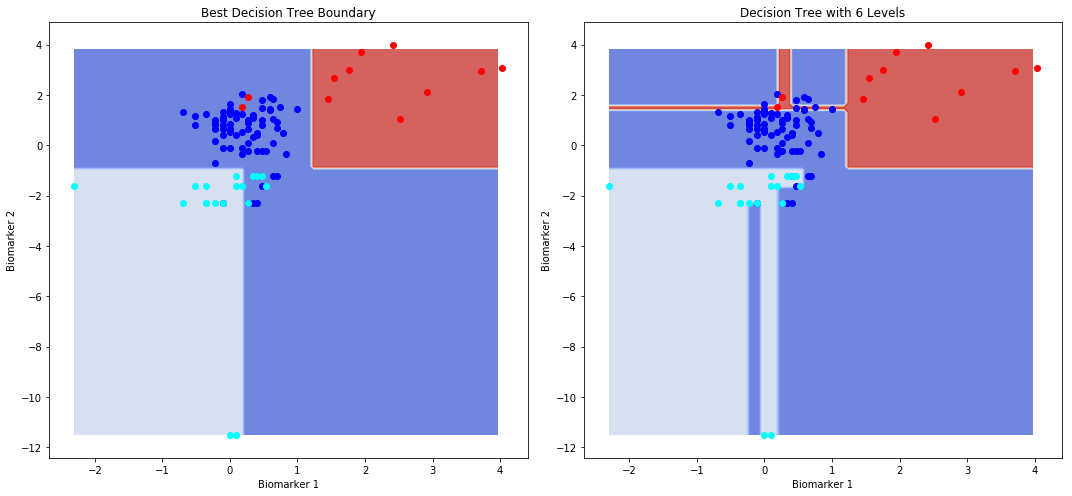

In [17]:
# Use the code provided in Part 2(c) to visualize the decision boundary of the fitted decision tree. 
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), dtc_best_mod, 
                                  'Best Decision Tree Boundary', ax[0], poly_degree = None)
dtc_mod = DecisionTreeClassifier(max_depth = 6)
dtc_mod.fit(Xtrain, ytrain)
ax[1] = plot_decision_boundary(np.asarray(Xtrain), np.asarray(ytrain), dtc_mod, 
                                  'Decision Tree with 6 Levels', ax[1], poly_degree = None)
plt.tight_layout()
plt.show()

#### Q: Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? 
Yes, the decision tree accuracy jumps from 92% to 96% at a depth of 4, and then plateaued at an accuracy of 97% at a depth of 6. 

#### Q: If so, what can you say about the test accuracy of this model?
The accuracy on the test set begins to suffer at a depth of 5 and is worse at a depth of 6. 

#### Q: How does the performance of a decision tree fitted with this depth compare with the models fitted in Part 2(a)?
The performance on the test set was much better than even the best performing model in part 2(a) -- k-Nearest Neighbors at 93.14%. However, the accuracy on the training data at 85% was amonth the only average among all of the predictors in part 2a (better than OvR, Linear and Quadratic Discriminant Analysis, worse than Multinomial, Multiclass with quadratic terms, and k-NN)


#### Q: How is the decision boundary of the decision tree model different from the other methods? Given an explanation for your observation.
The decision boundary is made up entirely of straight horizontal and vertical lines, as opposed to the other decision boundaries which could form curves and diagonal lines. This is because decision trees make decisions at nodes based on only one predictor at a time. "Is biomarker 1 greater than or less than 0.3?" In this case, that node would be represented by a vertical line where biomarker 1 = 0.3. The other models are able to make decisions based on multiple predictors at a time, so their decision boundaries are represented by multi variable equations.

#### Q: Based on the visualization, explain in words how the fitted model diagnoses 'hypothyroidism' for a patient.

Based on visual inspection, Hypothyroidism, in red, is biomarker 1 > 1.2 and biomarker 2 > -1. 

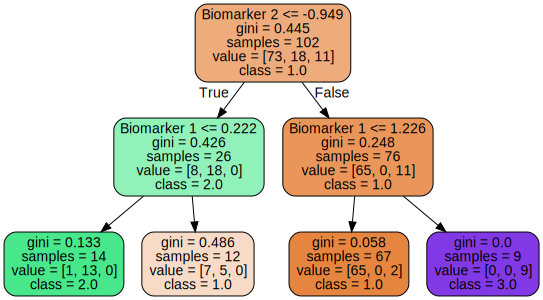

In [18]:
# Use the export_graphviz function in sklearn to generate 
# a visualization of the tree diagram for the fitted model. 
from IPython.display import SVG
from graphviz import Source
from sklearn import tree

graph = Source(tree.export_graphviz(dtc_best_mod,
                                    out_file      = None, 
                                    feature_names = Xtrain.columns,
                                    class_names   = list(map(str, np.unique(list(ytrain)))),
                                    filled        = True,
                                    rounded       = True
                                   ))
SVG(graph.pipe(format='svg'))

## Question 4: Too many models to choose from!

We have so far seen six different ways of fitting a classification model for thyroid classification problem: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **k-NN** and **decision tree**. Which of these methods should one use in practice? To answer this question, we now look at the pros and cons of each method.

1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability

2. If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 



1. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Ease of interpretability
  
In addition, we added "time to fit" as a metric -- the time, in milliseconds, to fit the model to the training data.
  

Classification Model| Time to fit (ms) | Classification performance|Complexity of decision boundary|Memory storage|Ease of interpretability
    ---------------------------------------------------:|-------------:|-------------:|
    Multinomial Logistic Regression|113|0.885|Low|Low|Okay|
    one-vs-rest (OvR) logistic regression|146|0.84|Low|Low| Poor|
    Multiclass Logistic Regression with quadratic terms|385|0.894|Med|Low| Poor|
    Linear Discriminant Analysis|2|0.832|Low|Low|Poor |
    Quadratic Discriminant Analysis|4 |0.850|Med|Low| Poor |
    k-Nearest Neighbors |328|0.867|High|High| Okay |
    Decision Tree|1|0.912|Low| Medium | Good |


#### Q: If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? 

Decision Tree Classifier - It yielded the best test accuracy, is the most interpretable, and provided the fastest fit, which is desirable for large datasets. The memory storage for the model is somewhat higher than for other models that can be represented as simple equations, but it is still not large, and does not scale with the data like the model for k-Nearest Neighbors does.

## Question 5: Including an 'abstain' option

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction, whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost. How does one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

1. More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model from Question 1, Part 3? Note that this needs to be evaluated on the patients in the test set. Your task is to design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient.   Give a justification for your approach.

2. **Presentation:** Prepare a set of 5 slides explaining your approach to the hospital management. Your presentation must be accessible to the lay man. Explain in particular how your approach would be robust to changes in the costs of using the abstain option.

*Hint:* think of a way to use the estimated probabilities from the logistic regression model to decide who to classify as *abstain*.

In [6]:
ovr_mod = LogisticRegressionCV(penalty='l2', multi_class='ovr')

ovr_mod.fit(Xtrain, ytrain)


print ("OVR Train Accuracy:  " + str(ovr_mod.score(Xtrain, ytrain)))
print ("OVR Test Accuracy:   " + str(ovr_mod.score(Xtest, ytest)))
print("Probabilities: ")

test_probabilities = [np.max(proba) for proba in ovr_mod.predict_proba(Xtest)]
print(np.mean(test_probabilities))
print(np.std(test_probabilities))


OVR Train Accuracy:  0.843137254902
OVR Test Accuracy:   0.840707964602
Probabilities: 
0.822748543136
0.152317795264


{'abstentions': 12, 'correct': 92, 'missed': 9, 'cost': 57000, 'probas': [0.95230244083893534, 0.95840202911544892, 0.96871180757602438, 0.96466855976151256, 0.96334035230965298, 0.95845008331748427, 0.95894309778696007, 0.92316404483906322, 0.88682793539390437, 0.95617353615213752, 0.95202972394300334, 0.95272481897814709, 0.67695065034974311, 0.64329665940664926, 0.90162907990060448, 0.85292036659715864, 0.62249773586897716, 0.94371494058711136, 0.924171845160766, 0.95319037670395312, 0.99166825834036254, 0.67466710676941233, 0.82524432010700033, 0.94004433959227085, 0.76990558730923575, 0.8598274675518992, 0.81599250105634835, 0.95665732449846941, 0.62030890331883926, 0.85425870356362021, 0.95561107300348913, 0.94782327694345325, 0.85283048334706368, 0.90952559505413755, 0.93889598668570329, 0.94296609929719699, 0.71676154468800313, 0.83145994814549729, 0.59289017184487081, 0.90162907990060448, 0.83145994814549729, 0.60189117948727944, 0.73287266012288321, 0.96582221895891507, 0.619

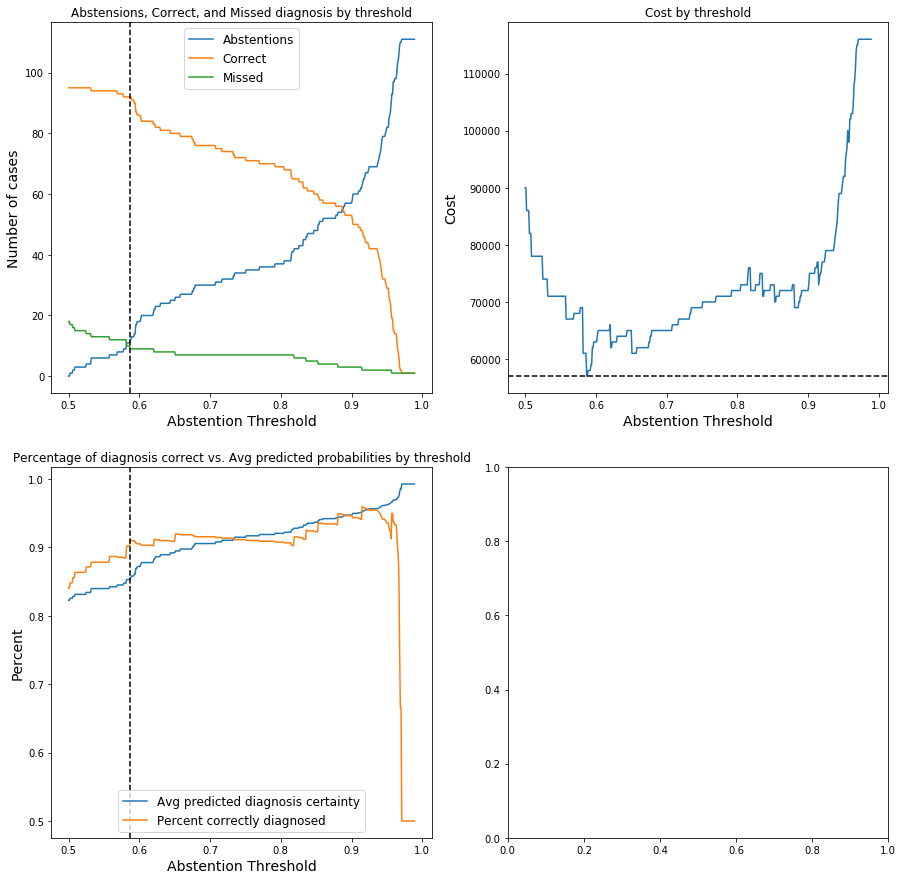

In [57]:
def calculate_profit(model, X, y, abstain_threshold):
    probas = [np.max(proba) for proba in model.predict_proba(X)]
    predicts = model.predict(X)
    
    scores = {'abstentions': 0, 'correct': 0, 'missed': 0, 'cost': 0, 'probas': []}
    for i in range(len(probas)):
        if probas[i] > abstain_threshold:
            scores['probas'].append(probas[i])
            if predicts[i] != y.iloc[i]:
                scores['missed'] += 1
                # Whoops, bad diagnosis!
                scores['cost'] += 5000
            else:
                scores['correct'] += 1
        else:
            # Send to the specialist. Pay $1,000
            scores['abstentions'] += 1
            scores['cost'] += 1000
    return scores

scores = []
thresholds = list(np.arange(.50, .99, .001))

for threshold in thresholds:
    score = calculate_profit(ovr_mod, Xtest, ytest, threshold)
    scores.append(score)

lowest_cost_idx = np.argmin([score['cost'] for score in scores])

fig, ax = plt.subplots(2, 2, figsize=(15, 15))


ax[0][0].plot(thresholds, [score['abstentions'] for score in scores], label='Abstentions')
ax[0][0].plot(thresholds, [score['correct'] for score in scores], label='Correct')
ax[0][0].plot(thresholds, [score['missed'] for score in scores], label='Missed')

ax[0][0].set_title('Abstensions, Correct, and Missed diagnosis by threshold')
ax[0][0].set_xlabel('Abstention Threshold', fontsize = 14)
ax[0][0].set_ylabel('Number of cases',   fontsize = 14)
ax[0][0].legend(fontsize = 12, loc = 'upper center')
ax[0][0].axvline(x = thresholds[lowest_cost_idx], color='black', linestyle='dashed')


ax[0][1].plot(thresholds, [score['cost'] for score in scores])
ax[0][1].set_title('Cost by threshold')
ax[0][1].set_xlabel('Abstention Threshold', fontsize = 14)
ax[0][1].set_ylabel('Cost',   fontsize = 14)

ax[0][1].axhline(y = scores[lowest_cost_idx]['cost'], color='black', linestyle='dashed')

percent_correct = [score['correct']/(score['correct']+score['missed']) for score in scores]
avg_probas = [np.mean(score['probas']) if score['probas'] else None for score in scores]
ax[1][0].set_title('Percentage of diagnosis correct vs. Avg predicted probabilities by threshold')
ax[1][0].plot(thresholds, avg_probas, label='Avg predicted diagnosis certainty')
ax[1][0].plot(thresholds, percent_correct, label='Percent correctly diagnosed ')
ax[1][0].set_xlabel('Abstention Threshold', fontsize = 14)
ax[1][0].set_ylabel('Percent',   fontsize = 14)
ax[1][0].legend(fontsize = 12, loc = 'lower center')
ax[1][0].axvline(x = thresholds[lowest_cost_idx], color='black', linestyle='dashed')
print(scores[lowest_cost_idx])
print(np.mean(scores[lowest_cost_idx]['probas']))

/Users/rmitchell/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rmitchell/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


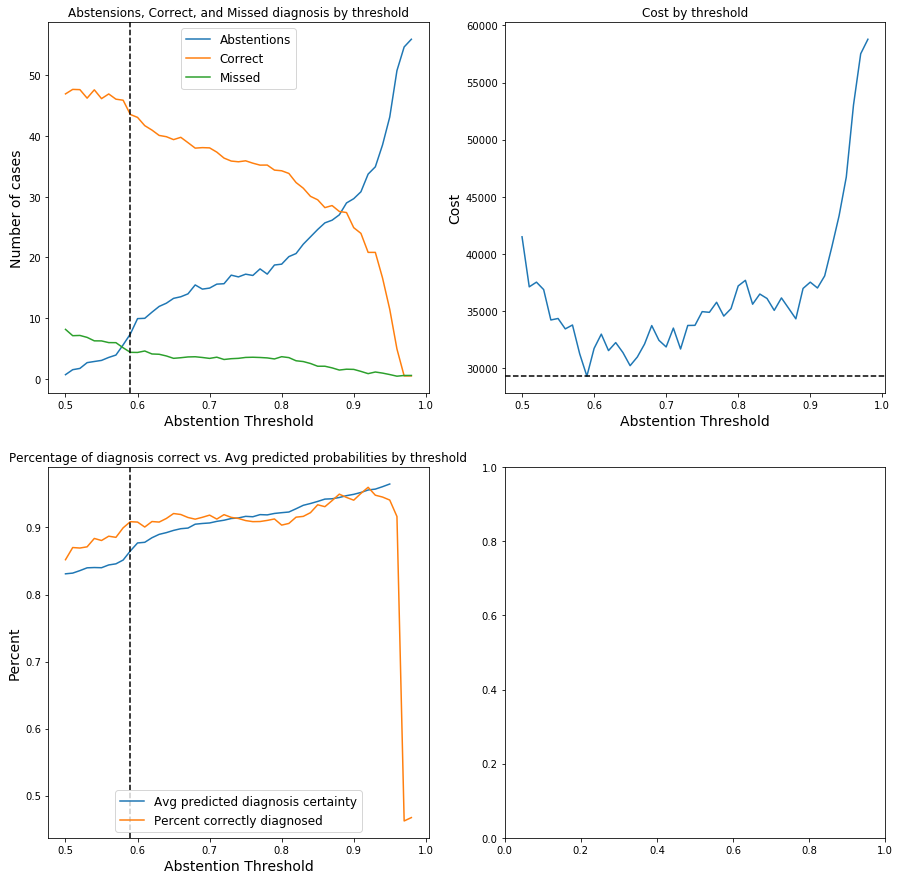

In [52]:
def get_samples():
    msk = np.random.rand(len(Xtest)) < 0.5
    return Xtest[msk], ytest[msk]

def avg_scores(scores):
    {'abstentions': 0, 'correct': 0, 'missed': 0, 'cost': 0, 'probas': []}
    score = {}
    score['abstentions'] = np.mean([score['abstentions'] for score in scores])
    score['correct'] = np.mean([score['correct'] for score in scores])
    score['missed'] = np.mean([score['missed'] for score in scores])
    score['cost'] = np.mean([score['cost'] for score in scores])
    score['probas'] = np.mean([np.mean(score['probas']) for score in scores])
    return score

scores = []
thresholds = list(np.arange(.50, .99, .001))
scores = []
for threshold in thresholds:
    threshold_scores = []
    for i in range(0, 10):
        Xtest_samp, ytest_samp = get_samples()
        threshold_scores.append(calculate_profit(ovr_mod, Xtest_samp, ytest_samp, threshold))
    scores.append(avg_scores(threshold_scores))

#Smooth the scores out by averaging along threshold from .1% increments to 1% increments
smoothed_scores = []
for i in range(1, int(len(scores)/10)+1):
    smoothed_scores.append(avg_scores(scores[(i-1)*10:i*10]))
scores = smoothed_scores
thresholds = list(np.arange(.50, .99, .01))
lowest_cost_idx = np.argmin([score['cost'] for score in scores])

fig, ax = plt.subplots(2, 2, figsize=(15, 15))


ax[0][0].plot(thresholds, [score['abstentions'] for score in scores], label='Abstentions')
ax[0][0].plot(thresholds, [score['correct'] for score in scores], label='Correct')
ax[0][0].plot(thresholds, [score['missed'] for score in scores], label='Missed')

ax[0][0].set_title('Abstensions, Correct, and Missed diagnosis by threshold')
ax[0][0].set_xlabel('Abstention Threshold', fontsize = 14)
ax[0][0].set_ylabel('Number of cases',   fontsize = 14)
ax[0][0].legend(fontsize = 12, loc = 'upper center')
ax[0][0].axvline(x = thresholds[lowest_cost_idx], color='black', linestyle='dashed')


ax[0][1].plot(thresholds, [score['cost'] for score in scores])
ax[0][1].set_title('Cost by threshold')
ax[0][1].set_xlabel('Abstention Threshold', fontsize = 14)
ax[0][1].set_ylabel('Cost',   fontsize = 14)

ax[0][1].axhline(y = scores[lowest_cost_idx]['cost'], color='black', linestyle='dashed')

percent_correct = [score['correct']/(score['correct']+score['missed']) for score in scores]
avg_probas = [np.mean(score['probas']) if score['probas'] else None for score in scores]
ax[1][0].set_title('Percentage of diagnosis correct vs. Avg predicted probabilities by threshold')
ax[1][0].plot(thresholds, avg_probas, label='Avg predicted diagnosis certainty')
ax[1][0].plot(thresholds, percent_correct, label='Percent correctly diagnosed ')
ax[1][0].set_xlabel('Abstention Threshold', fontsize = 14)
ax[1][0].set_ylabel('Percent',   fontsize = 14)
ax[1][0].legend(fontsize = 12, loc = 'lower center')
ax[1][0].axvline(x = thresholds[lowest_cost_idx], color='black', linestyle='dashed')


In [ ]:
# Get scores only within range
